In [9]:
import random # para barajar estudiantes que no tienen restricciones
import networkx as nx # creación de grafos con opciones de personalización
import matplotlib.pyplot as plt # mostrar grafos con títulos y disposiciones 
import pandas as pd # tabular datos

def crearGrupos(clase, tamanioGrupos, juntos, separados, archivo_html="grupos.html"):
    random.seed(int(12345)) # para obtener los mismos datos en todas las salidas
    # Paso 0. Validaciones previas
    numGrupos = (len(clase) + tamanioGrupos - 1) // tamanioGrupos  # Redondear hacia arriba para asegurar los grupos
    
    # Verificar que ninguno de los grupos en 'juntos' tenga más estudiantes que el tamaño del grupo
    for subgrupo in juntos:
        if len(subgrupo) > tamanioGrupos:
            raise ValueError(f"Error. El subgrupo {subgrupo} no puede ir junto porque su tamaño excede el tamaño de los grupos ({tamanioGrupos}).")
    
    # Verificar que no haya más combinaciones de 'separados' que grupos disponibles
    for subgrupo in separados:
        if len(subgrupo) > numGrupos:
            raise ValueError(f"Error. El subgrupo de estudiantes {subgrupo} tiene más estudiantes que los grupos disponibles ({numGrupos}). No se puede separar.")
    
    # Verificar que no haya combinaciones imposibles: 
    # Es decir, verificar que no haya estudiantes que estén en listas 'juntos' y 'separados' al mismo tiempo
    for subgrupo_separado in separados:
        for estudiante in subgrupo_separado:
            for subgrupo in juntos:
                if estudiante in subgrupo:
                    raise ValueError(f"Error. El estudiante {estudiante} está en una combinación de 'juntos' y 'separados', lo que genera un conflicto.")
    
    # Paso 1. Inicializar los grupos vacíos
    grupos = [[] for _ in range(numGrupos)]
    
    # Paso 2. Asegurarse de que los estudiantes de 'juntos' estén en el mismo grupo
    grupo_indx = 0
    for subgrupo in juntos:
        if grupo_indx < numGrupos and len(grupos[grupo_indx]) + len(subgrupo) <= tamanioGrupos:
            grupos[grupo_indx].extend(subgrupo)
            grupo_indx = (grupo_indx + 1) % numGrupos

    # Paso 3. Distribuir los estudiantes 'separados' entre los grupos
    grupo_indx = 0
    for subgrupo in separados:
        for estudiante in subgrupo:
            while len(grupos[grupo_indx]) >= tamanioGrupos:  # Buscar grupo no lleno
                grupo_indx = (grupo_indx + 1) % numGrupos
            grupos[grupo_indx].append(estudiante)
            grupo_indx = (grupo_indx + 1) % numGrupos # Avanzar al siguiente grupo para el siguiente estudiante
    # Paso adicional para verificar que no haya estudiantes de 'separados' en el mismo grupo
    for subgrupo_separado in separados:
        for i, estudiante1 in enumerate(subgrupo_separado):
            for estudiante2 in subgrupo_separado[i+1:]:
                # Verificar que ninguno de los estudiantes que deben estar separados caiga en el mismo grupo
                for grupo in grupos:
                    if estudiante1 in grupo and estudiante2 in grupo:
                        raise ValueError(f"Error. No es posible esta combinación dado que los estudiantes {estudiante1} y {estudiante2} estarían en el mismo grupo.")

    
    # Paso 4. Eliminar los estudiantes ya asignados de la lista de clase
    estudiantes_asignados = [e for grupo in grupos for e in grupo]
    clase_restante = [est for est in clase if est not in estudiantes_asignados]
    
    # Paso 5. Rellenar los grupos con los estudiantes restantes
    # Mezclamos aleatoriamente los estudiantes que aún no han sido asignados (clase_restante),
    # y luego, iteramos por cada grupo para completarlo hasta alcanzar el tamaño máximo permitido (tamanioGrupos).
    # Para cada grupo, mientras haya espacio disponible y queden estudiantes en clase_restante,
    # vamos extrayendo el último estudiante de clase_restante (usando pop) y lo añadimos al grupo.
    random.shuffle(clase_restante)
    for grupo in grupos:
        while len(grupo) < tamanioGrupos and clase_restante:
            grupo.append(clase_restante.pop())

    def mostrarDiagramasDeGrupos(grupos, figsize=(15, 10)):
        # Calcular el número de filas necesarias para organizar los diagramas en 3 columnas
        n_cols = 3
        n_rows = (len(grupos) + n_cols - 1) // n_cols  # Redondear hacia arriba

        # Crear una figura con subplots. Esto nos devolverá una sola imagen en lugar de tantas como grupos haya
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        axes = axes.flatten()  # Convertir la matriz de ejes en una lista plana para iterar más fácilmente

        for i, (grupo, ax) in enumerate(zip(grupos, axes)):
            # Crear el grafo para este grupo
            G = nx.Graph()

            # Nodo que representa al grupo
            grupo_nodo = f"Grupo {i+1}"
            G.add_node(grupo_nodo, color='#9d8189', size=4000, edgecolors="#9d8189")  # Nodo grande para el grupo

            # Añadir los nodos de los estudiantes
            for estudiante in grupo:
                G.add_node(estudiante, color='#ffcad4', size=2000, edgecolors="#ffcad4")  # Nodo pequeño para los estudiantes
                G.add_edge(grupo_nodo, estudiante)  # Conexión del grupo con el estudiante

            # Colores y tamaños de los nodos
            colors = [G.nodes[n].get('color', 'lightgray') for n in G.nodes]
            sizes = [G.nodes[n].get('size', 3000) for n in G.nodes]

            # Posicionamiento automático del grafo con spring
            pos = nx.spring_layout(G)

            # Dibujar el grafo en el subplot correspondiente
            nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=sizes, ax=ax)
            nx.draw_networkx_edges(G, pos, edge_color="black", alpha=0.5, ax=ax)
            nx.draw_networkx_labels(G, pos, font_size=10, font_color="black", ax=ax)

            # Título del subplot
            ax.set_title(f"Grupo {i+1}", fontsize=14, style='italic')
            ax.axis("off")  # No mostrar los ejes

        # Eliminar los subplots vacíos si hay menos grupos que subplots
        for ax in axes[len(grupos):]:
            ax.axis("off")

        # Ajustar el espacio entre los subplots
        plt.tight_layout()
        plt.show()


    mostrarDiagramasDeGrupos(grupos)
    
    return grupos

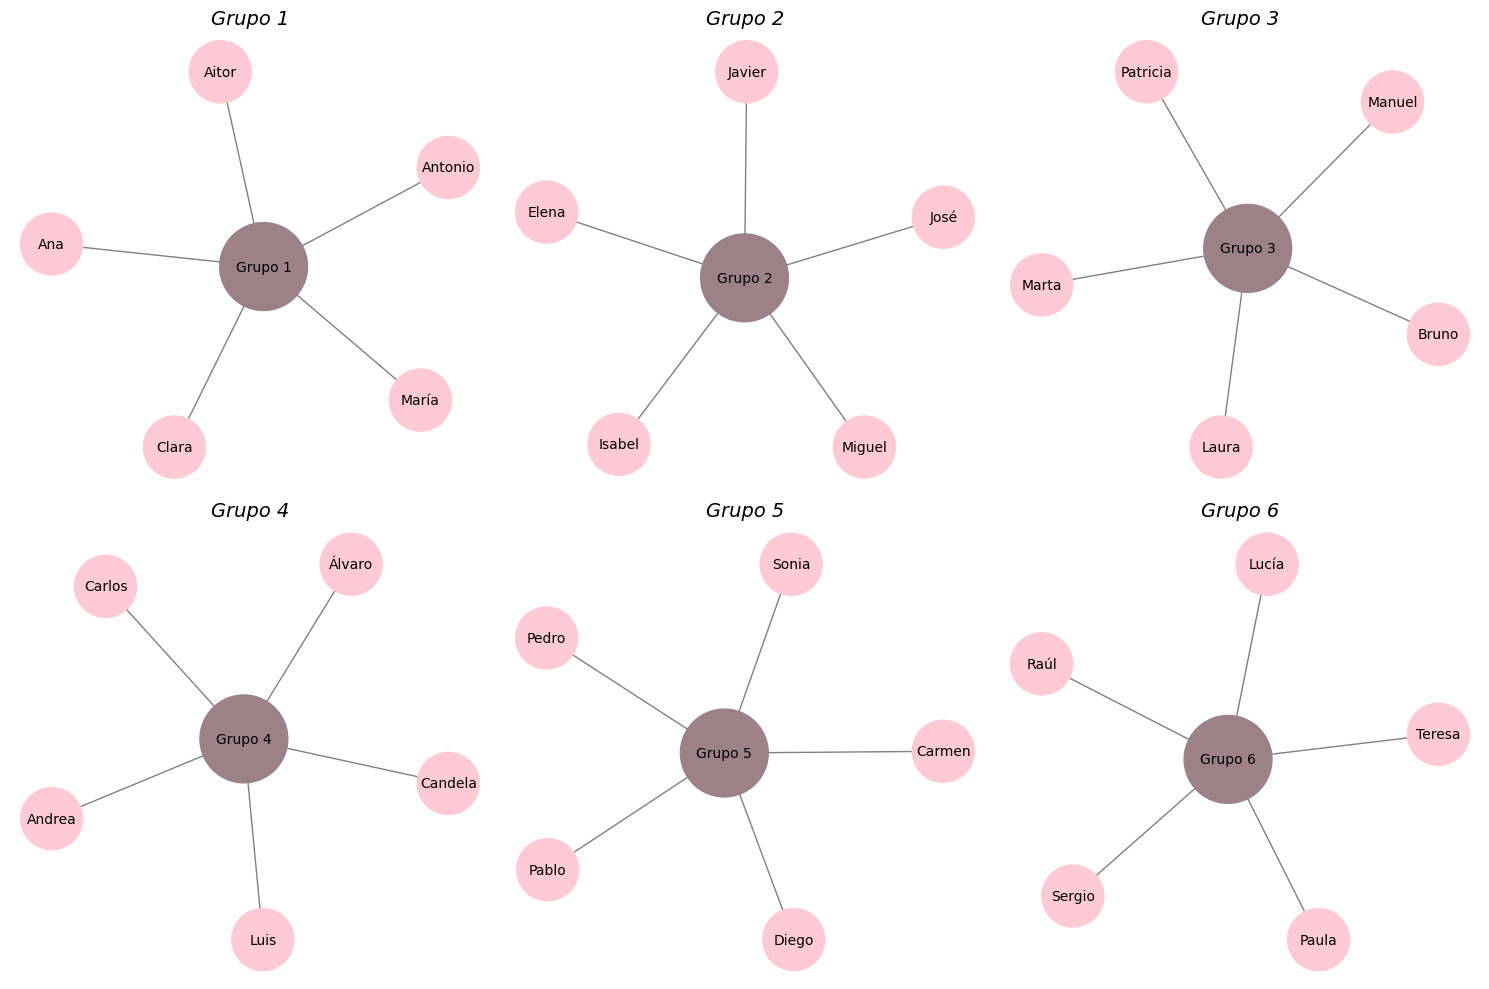

In [10]:
# Ejemplo de uso:
clase = ['Antonio', 'Candela', 'José', 'Bruno', 'Aitor', 'Ana', 'María', 'Sonia', 'Marta', 
         'Luis', 'Lucía', 'Carlos', 'Laura', 'Miguel', 'Carmen', 'Javier', 'Isabel', 'Pedro', 
         'Elena', 'Sergio', 'Clara', 'Pablo', 'Patricia', 'Raúl', 'Andrea', 'Álvaro', 'Teresa', 
         'Diego', 'Paula', 'Manuel']
tamanioGrupos = 5
juntos = [['Antonio', 'Ana']] 
separados = [['Aitor', 'José', 'Bruno'], ['Candela', 'Sonia']]

grupos = crearGrupos(clase, tamanioGrupos, juntos, separados)

In [20]:
# Ejemplo de uso. Error porque hay un grupo de estudiantes separados que tiene más integrantes que número
# de grupos.
clase = ['Antonio', 'Candela', 'José', 'Bruno', 'Aitor', 'Ana', 'María', 'Sonia', 'Marta', 'Adrián']
tamanioGrupos = 5
juntos = [['Antonio', 'Ana'], ['María', 'Marta']] 
separados = [['Aitor', 'José','Bruno'], ['Candela', 'Sonia']]

try:
    grupos = crearGrupos(clase, tamanioGrupos, juntos, separados)

    # Mostrar los grupos generados
    for i, grupo in enumerate(grupos, 1):
        print(f"Grupo {i}: {grupo}")
except ValueError as e:
    print(e)

Error. El subgrupo de estudiantes ['Aitor', 'José', 'Bruno'] tiene más estudiantes que los grupos disponibles (2). No se puede separar.


In [21]:
# Ejemplo de uso. Error porque hay un grupo de estudiantes juntos que tiene más integrantes que integrantes
# de grupo permitidos.
clase = ['Antonio', 'Candela', 'José', 'Bruno', 'Aitor', 'Ana', 'María', 'Sonia', 'Marta', 'Adrián']
tamanioGrupos = 2
juntos = [['Antonio', 'Ana', 'María']] 
separados = [['Aitor', 'José','Bruno'], ['Candela', 'Sonia']]

try:
    grupos = crearGrupos(clase, tamanioGrupos, juntos, separados)

    # Mostrar los grupos generados
    for i, grupo in enumerate(grupos, 1):
        print(f"Grupo {i}: {grupo}")
except ValueError as e:
    print(e)

Error. El subgrupo ['Antonio', 'Ana', 'María'] no puede ir junto porque su tamaño excede el tamaño de los grupos (2).


In [22]:
# Ejemplo de uso. Estudiante en juntos y separados.
clase = ['Antonio', 'Candela', 'José', 'Bruno', 'Aitor', 'Ana', 'María', 'Sonia', 'Marta', 'Adrián']
tamanioGrupos = 2
juntos = [['Antonio', 'Ana']]  
separados = [['Antonio', 'José'], ['Candela', 'Sonia']]

try:
    grupos = crearGrupos(clase, tamanioGrupos, juntos, separados)

    # Mostrar los grupos generados
    for i, grupo in enumerate(grupos, 1):
        print(f"Grupo {i}: {grupo}")
except ValueError as e:
    print(e)

Error. El estudiante Antonio está en una combinación de 'juntos' y 'separados', lo que genera un conflicto.


In [23]:
# Ejemplo de uso. Combinación imposible.
clase = ['Antonio', 'Candela', 'José', 'Bruno', 'Aitor', 'Ana', 'María', 'Sonia', 'Marta']
tamanioGrupos = 3
juntos = [['Antonio', 'Ana', 'María']]  
separados = [['Aitor', 'José','Bruno'], ['Candela', 'Sonia']]

try:
    grupos = crearGrupos(clase, tamanioGrupos, juntos, separados)

    # Mostrar los grupos generados
    for i, grupo in enumerate(grupos, 1):
        print(f"Grupo {i}: {grupo}")
except ValueError as e:
    print(e)

Error. No es posible esta combinación dado que los estudiantes Aitor y Bruno estarían en el mismo grupo.


Bienvenido al generador de grupos.
Introduce los datos de la clase:


Escribe los nombres de los estudiantes separados por comas:  Antonio, Candela, José, Bruno, Aitor, Ana, María, Sonia, Marta, Luis, Lucía, Carlos, Laura, Miguel, Carmen, Javier, Isabel, Pedro, Elena, Sergio, Clara, Pablo, Patricia, Raúl, Andrea, Álvaro, Teresa, Diego, Paula, Manuel

¿Cuál es el tamaño máximo de los grupos?  5


Ahora indica los estudiantes que deben estar juntos.
Escribe cada grupo en una línea separados por comas. Deja la línea vacía para continuar.


Estudiantes juntos:  Antonio, Ana

Estudiantes juntos:  


Ahora indica los estudiantes que deben estar separados.
Escribe cada grupo en una línea separados por comas. Deja la línea vacía para continuar.


Estudiantes separados:  José, Bruno, Aitor

Estudiantes separados:  Candela, Sonia

Estudiantes separados:  

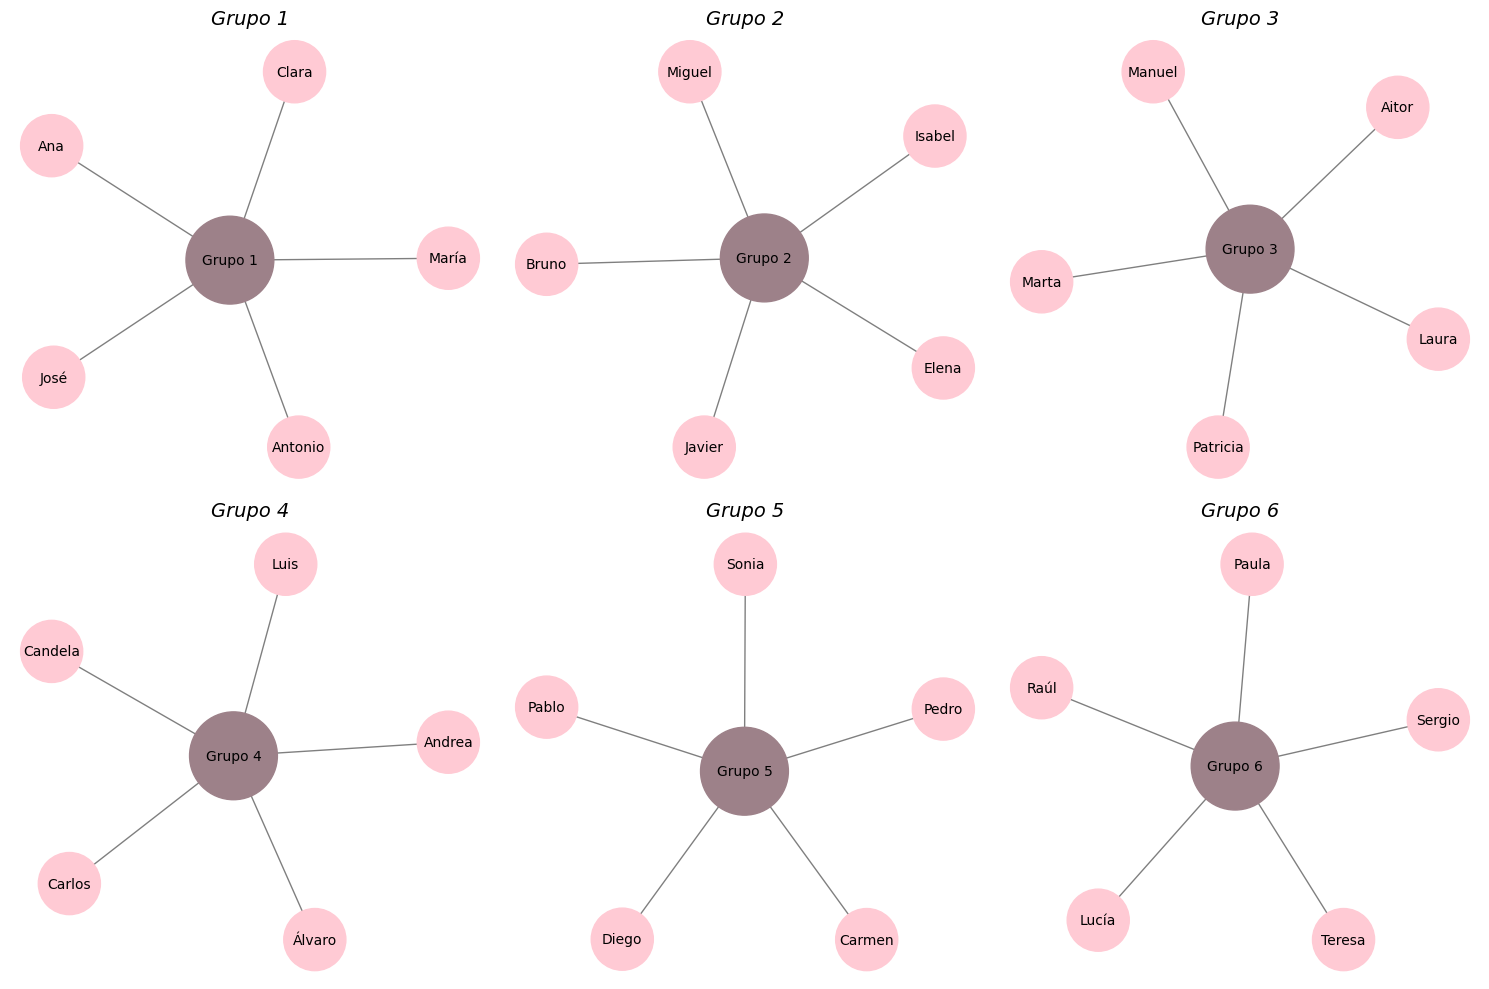


¡Grupos generados con éxito!
Grupo 1. Antonio, Ana, José, Clara, María
Grupo 2. Bruno, Isabel, Elena, Miguel, Javier
Grupo 3. Aitor, Manuel, Laura, Patricia, Marta
Grupo 4. Candela, Álvaro, Carlos, Andrea, Luis
Grupo 5. Sonia, Pedro, Diego, Carmen, Pablo
Grupo 6. Paula, Lucía, Sergio, Teresa, Raúl



¿Deseas exportar los resultados a un archivo CSV? (si/no):  si

Nombre del archivo (ejemplo: grupos.csv):  grupos.csv

Resultados exportados a grupos.csv


In [11]:
def solicitar_datos():
    set_random_seed(12345)
    print("Bienvenido al generador de grupos.")
    print("Introduce los datos de la clase:")
    
    # Solicitar lista de estudiantes
    clase = input("Escribe los nombres de los estudiantes separados por comas: ").split(",")
    clase = [nombre.strip() for nombre in clase if nombre.strip()]
    
    # Solicitar tamaño de los grupos
    while True:
        try:
            tamanioGrupos = int(input("¿Cuál es el tamaño máximo de los grupos? "))
            # Contemplamos posibles errores del usuario
            if tamanioGrupos <= 0:
                raise ValueError("El tamaño debe ser mayor a 0.")
            break
        except ValueError as e:
            print(f"Entrada inválida: {e}")
    
    # Solicitar listas de 'juntos'
    juntos = []
    print("\nAhora indica los estudiantes que deben estar juntos.")
    print("Escribe cada grupo en una línea separados por comas. Deja la línea vacía para continuar.")
    while True:
        subgrupo = input("Estudiantes juntos: ").split(",")
        subgrupo = [nombre.strip() for nombre in subgrupo if nombre.strip()]
        if not subgrupo:
            break
        juntos.append(subgrupo)
    
    # Solicitar listas de 'separados'
    separados = []
    print("\nAhora indica los estudiantes que deben estar separados.")
    print("Escribe cada grupo en una línea separados por comas. Deja la línea vacía para continuar.")
    while True:
        subgrupo = input("Estudiantes separados: ").split(",")
        subgrupo = [nombre.strip() for nombre in subgrupo if nombre.strip()]
        if not subgrupo:
            break
        separados.append(subgrupo)
    
    return clase, tamanioGrupos, juntos, separados

def crearGruposInteractivo():
    # Solicitar datos al usuario
    clase, tamanioGrupos, juntos, separados = solicitar_datos()
    
    try:
        # Generar los grupos
        grupos = crearGrupos(clase, tamanioGrupos, juntos, separados)
        
        # Mostrar resultados
        print("\n¡Grupos generados con éxito!")
        for i, grupo in enumerate(grupos, 1):
            print(f"Grupo {i}. {', '.join(grupo)}")
        
        # Ofrecer exportar resultados
        exportar = input("\n¿Deseas exportar los resultados a un archivo CSV? (si/no): ").strip().lower()
        if exportar == "si":
            archivo = input("Nombre del archivo (ejemplo: grupos.csv): ").strip()
            data = {"Grupo": [f"Grupo {i+1}" for i in range(len(grupos))],
                    "Estudiantes": [', '.join(grupo) for grupo in grupos]}
            df = pd.DataFrame(data)
            df.to_csv(archivo, index=False)
            print(f"Resultados exportados a {archivo}")
    
    except ValueError as e:
        print(f"Error al generar los grupos: {e}")

# Ejecutar el programa interactivo
crearGruposInteractivo()